# Basics of mobile robotics 
## Report of Group 23

### Group 23 members : 

- Boshi An
- Grzegorz Statkiewicz
- Mael Studer
- Yasmine Tligui

### Succession of topics

1. [Introduction](#Introduction)
2. [Computer Vision](#Computer-Vision)
3. [Global Navigation](#Global-Navigation)
4. [Kalman Filter](#Kalman-Filter)
5. [PID Controller](#PID-Controller)
6. [Local Navigation](#Local-Navigation)
7. [Path Controller](#Path-Controller)
8. [Mission Planner](#Mission-Planner)
9. [Conclusion](#Conclusion)
10. [References](#References)
11. [Example Video](#Example-Video)

# Introduction 

It was a quiet night at the museum, just like every other one. The galleries stood still, with the soft glow of lights bouncing off ancient statues and priceless paintings. Thymio, the little robot guardian, rolled along his usual path, making sure everything was safe. This was his job: patrol the museum, follow the same route every night, and keep an eye out for anything unusual.

But tonight ? Tonight wasn’t going to be like the others.

As Thymio cruised past the grand staircase, something blinked red on his dashboard. An alert from the surveillance cameras. Someone had broken in. Thymio froze for a moment, running a quick check. It wasn’t just a false alarm. There was really someone moving through the museum.

And not just any intruder. This one wasn’t quietly sneaking around—oh no. This person was running all over the place, jumping from one corner to another, knocking over small objects, and deliberately messing with the cameras. It was almost like they were playing a game, trying to confuse the little robot.

For Thymio, it wasn’t just about catching the intruder. This was personal. The museum was his turf, his responsibility. If he couldn’t stop this troublemaker, what kind of guardian was he? 

In the end, despite his best efforts, Thymio couldn’t catch the intrudor. But failure wasn’t the end for Thymio, it was just the beginning of a new mission. That’s where we came in. Seeing Thymio’s potential, we decided to step in and help him become better, smarter, faster. Together, we started working on a plan to make sure that next time, things would be different. From teaching him new ways of navigation and obstacle avoidance to improving his computer vision skills, we set out to turn Thymio into the ultimate museum guardian. But there was still a critical problem we needed to solve. During his rounds, Thymio relied on his sensors and cameras to know where he is in the museum. What if the intruder tampered with these systems? What if Thymio got lost in the chaos, unable to figure out his own position? To ensure this never happened, we implemented a Kalman filter, to help Thymio track his own location with precision. And even in the worst case scenario, if the intruder were to kidnap Thymio abruptly moving him to a completely different location in the museum, the new system enables him to quickly recalibrate, determine his position, and recalculate a new global path to continue his pursuit directly.

The robot's software architecture is divided into modular structures, each responsible for a specific functionality. These components interact cohesively to achieve the overall objectives of navigation, object avoidance, and intruder pursuit. Let's see in detail how we managed to help Thymio to take revenge on the intruder

# Computer Vision

The computer vision module performs several key functions using OpenCV library to support the robot's navigation and tracking capabilities. Using arucos marker detection, it localizes the robot, identifies targets and the intruder, and delineates the map boundaries. It also discretizes images, for example to convert the map into a grid representation.

Below is an overview the different function we use in the cv part:

#### Capturing Frames from the Camera :

The entire Computer Vision (CV) process begins with the `_get_frame()` function, which captures a frame from the camera feed, serving as the entry point to construct our map representation. Since `cv2.VideoCapture` is used in this function, and it is not thread safe, to prevent race between two threads (we need multi-threading as explained in following sections), we used locks when accessing the `Camera` .

```python
def get_frame(self) :
    self.lock.acquire()
    if self.vc.isOpened() :
        rval, frame = self.vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        self.lock.release()
        return frame
    else :
        print("Camera not opened")
        self.lock.release()
        return None
```

#### Generating and Detecting ArUco Markers :
In our environment, we have ArUco markers that serve multiple purposes. Four of them define the map’s boundaries, enabling perspective correction to align the visual field with the physical space and the delimitation of the map. One marker is attached to the robot itself for real-time localization, and additional markers highlight specific targets or goal points within the environment. These markers are detected using the `_get_aruco_pose()` function, which identifies ArUco markers in a captured frame and calculates their pose relative to the camera, using a predefined dictionary containing the arUcos to detect. This enables accurate robot localization and precise navigation within the mapped environment.

```python
def _get_aruco_pose(frame) :

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected = detector.detectMarkers(gray)

    draw_frame = frame.copy()
    if ids is not None:
        cv2.aruco.drawDetectedMarkers(draw_frame, corners, ids)
    return draw_frame, corners, ids
```

#### Capturing and Transforming the Map :

To improve the image that we obtain from the camera, we used the `cv2.warpPerspective` function computes a mathematical transformation that adjusts the perspective of the captured map image to flatten the map, removing distortions caused by the camera angle. By using arUcos as reference points on the map, the function creates a transformation matrix that resizes and aligns the map to a standard, scaled format, ensuring it aligns accurately with a predefined coordinate system for consistency.
For subsequent tasks, to don't consider the arUcos as obstacles, we needed to remove them from our images, as they were no longer required for certain analyses. To achieve this, we created a function `_remove_arucos()`, that uses the coordinates location of our arUcos and uses cv2.fillPoly to overwrite the marker’s area with white. 

```python
def _get_persepective_transform(camera_pts, scaled_width=None, scaled_height=None, target_scale=None) :

    measured_height = np.linalg.norm(camera_pts[0] - camera_pts[3])
    measured_width = np.linalg.norm(camera_pts[1] - camera_pts[3])

    if not scaled_width or not scaled_height :
        assert(target_scale is not None)
        scaled_height = int(target_scale * measured_height / (measured_height + measured_height))
        scaled_width = int(target_scale * measured_width / (measured_height + measured_height))

    target_pts = np.array(
        [[0, scaled_height], [scaled_width, 0], [scaled_width, scaled_height], [0, 0]]
    ).astype(np.float32)

    persp_trans = cv2.getPerspectiveTransform(camera_pts, target_pts)

    return persp_trans, scaled_width, scaled_height

# Transforming the map with cv2.warpPerspective
persp_trans, scaled_width, scaled_height = _get_persepective_transform(
    camera_pts, # 
    target_scale=target_scale,
)

original_map = cv2.warpPerspective(map_frame, persp_trans, (scaled_width, scaled_height))
```

#### Extracting robot and map information :

The last two functions are exposed publicly to other modules.

To enable localization and navigation, the system relies on two key functions, `get_map_info()` and `get_robot_info()`, to manage map and robot data : 

The `get_map_info()` function processes map boundaries defined by four ArUco markers, calculates scaling factors such as cm_per_pixel, and retrieves map dimensions, both original and discretized, along with transformation matrices using all the function cited earlier in the other paragraphs. All the information is stored in the MapInfo class, which organizes attributes like the original and discretized maps and the transformation data. 

The `get_robot_info()` function detects the robot’s position and orientation, as well as the coordinates of target locations, using ArUco markers. This data is stored in the RobotInfo class, which centralizes information about the robot’s pose and the target positions. 

Together, these functions enable precise localization, navigation, and planning within the defined map boundaries.

Below is an example of how to use the two public functions:

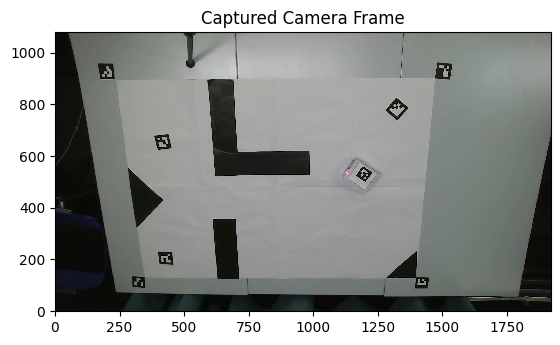

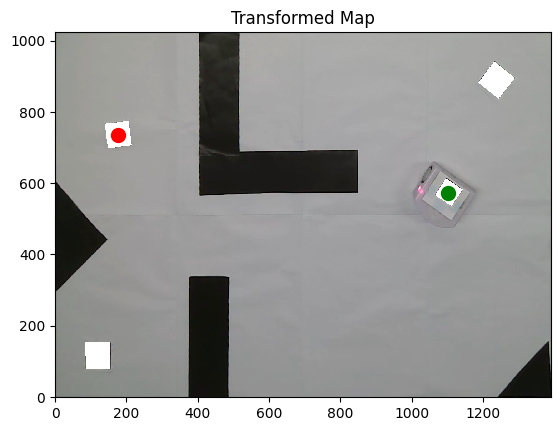

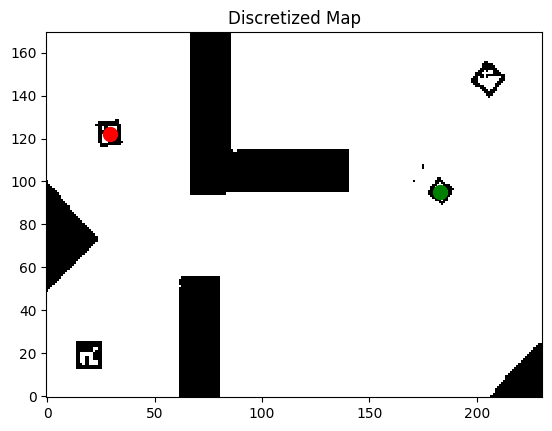

Robot pose: 572.7960815429688 1102.5047607421875 -2.157837390899658
Robot goal: 734.1452026367188 177.10211181640625
Map shape: 1024 1391
Checkpoints: [[ 120.177155  115.56612 ]
 [1235.7212    886.1647  ]]


In [1]:
from modules.cv import get_map_info, get_robot_info
from modules.utils import plot_map
from definitions import *
import cv2

map_frame = cv2.imread("resources/map_captures/map6.png")   # Load the map frame

map_info = get_map_info(
    map_frame,
    target_scale=MAP_TARGET_SCALE,
    descretize_scale=DESCRITIZE_SCALE,
    descretize_threshold=DESCRITIZE_THRESHOLD,        # This number needs to be changed based on the environment
    aruco_cm=ARUCO_SIZE_CM
)

robot_info = get_robot_info(
    map_frame,
    map_info.original_width,
    map_info.original_height
)

plot_map(
    map_frame,
    title="Captured Camera Frame"
)

plot_map(
    map_info.original_map,
    robot_pos=(robot_info.robot_x, robot_info.robot_y),
    target_pos=(robot_info.goal_x, robot_info.goal_y),
    title="Transformed Map",
)

plot_map(
    map_info.descretized_map,
    robot_pos=(robot_info.robot_x // map_info.descretize_scale, robot_info.robot_y // map_info.descretize_scale),
    target_pos=(robot_info.goal_x // map_info.descretize_scale, robot_info.goal_y // map_info.descretize_scale),
    title="Discretized Map",
)

print("Robot pose:", robot_info.robot_x, robot_info.robot_y, robot_info.robot_theta)
print("Robot goal:", robot_info.goal_x, robot_info.goal_y)
print("Map shape:", map_info.original_height, map_info.original_width)
print("Checkpoints:", robot_info.checkpoint_list)

# Global navigation 

The global navigation system is designed to enable the robot to plan an optimal path from a starting point to a target destination while accounting for obstacles in the environment. Using the discretized grid, this module detects key navigation points (corners of the obstacles), and constructs a graph of reachable connections between these points. Using this graph, the robot determines the shortest free path between the given start and end points.



To perform the global navigation, we've created class `GlobalNavigation`. Firstly as an input we need captured frame of the map of size `N x M`

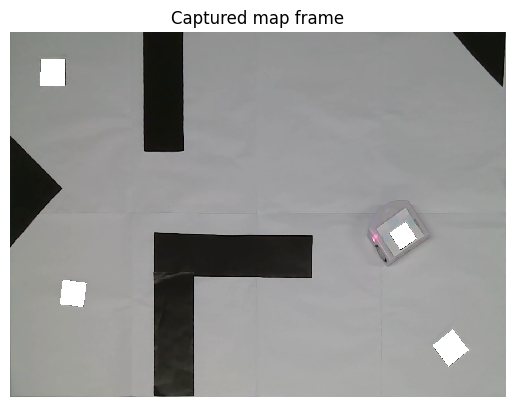

Captured frame is of size: (1024, 1391, 3)


In [2]:
from modules.cv import read_image, display_image, get_map_info

# Read the camera frame and get the map info
camera_frame = read_image('./resources/map_captures/map6.png')
map_info = get_map_info(camera_frame)

display_image(map_info.original_map, title="Captured map frame")
print("Captured frame is of size:", map_info.original_map.shape)

Then, to dircretize the map using provided `discretized_threshold` and `discretized_scale`, we create a grid of size `K x L` where `K = N // discretized_scale`, `L = M // discretized_scale`. This grid is used to represent the map in a more structured way, where each cell is either an obstacle or a free space. To determine which cells are obstacles, we use the threshold value to compare it with the intensity of the pixel. If the intensity is lower than the threshold, the cell is considered an obstacle, otherwise it is a free space.

22


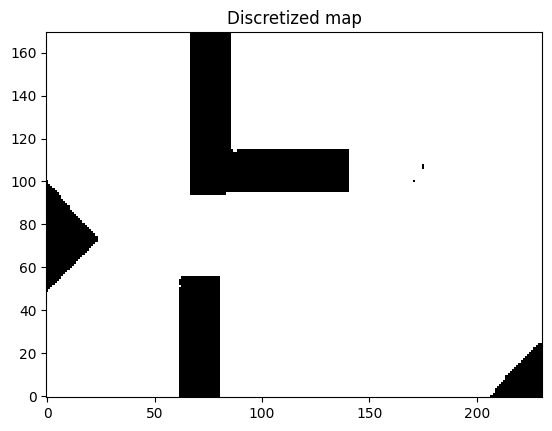

In [3]:
from modules.utils import plot_map
from modules.global_navigation import GlobalNavigation
from definitions import *

gn = GlobalNavigation(
    map_image=map_info.original_map, 
    discretize_scale=DESCRITIZE_SCALE, 
    discretize_threshold=DESCRITIZE_THRESHOLD, 
    thymio_size_in_pixels=ROBOT_RADIUS_CM / map_info.cm_per_pixel,
    small_obstacle_area_in_pixels=REMOVE_SMALL_OBSTACLES_IN_CM2 // (map_info.cm_per_pixel ** 2))

discretized_map = gn.discretized_map

plot_map(discretized_map, title="Discretized map")

Instead of using the discretized map directly, small obstacle regions are detected using the `extract_regions()` function which . This step, handled by the `_remove_small_objects()` function, which identifies components in the grid and discards those smaller than a predefined size. This process does not affect the presence of real obstacles, as these are large enough to meet the size threshold and remain intact. Instead, it primarily removes noise, such as fragments that do not represent meaningful barriers in the environment.

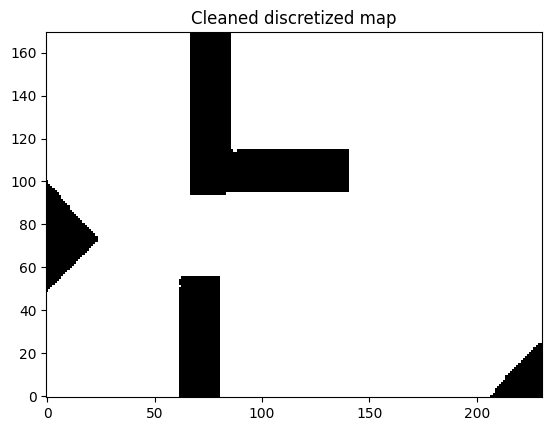

In [4]:
cleaned_discretized_map = gn.cleaned_discretized_map

plot_map(cleaned_discretized_map, title="Cleaned discretized map")

To account for the robot's size in the path drawing, the `_expand_obstacles()` function increases obstacle areas by adding a buffer around them, ensuring narrow passages too small for the robot are marked as impassable and  guarantees safe navigation margins to the obstacles.

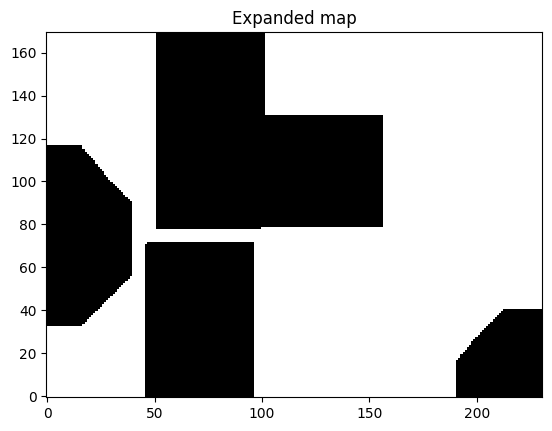

In [5]:
expanded_map = gn.expanded_map

plot_map(expanded_map, title="Expanded map")

After expanding obstacles, the `extract_corners()` function applies the Shi-tomasi corner detection algorithm to identify key navigation points in the map. These corners serve as nodes in the graph, representing critical points where the robot may need to turn or change direction.

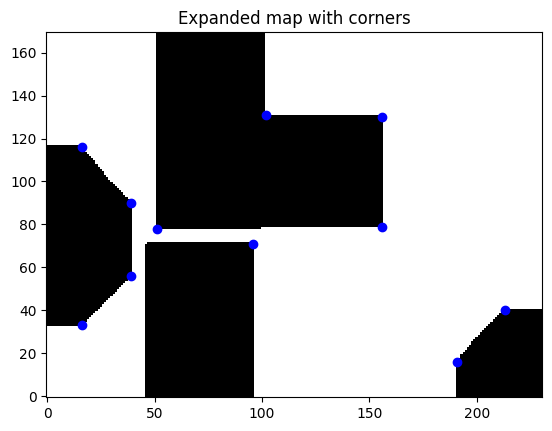

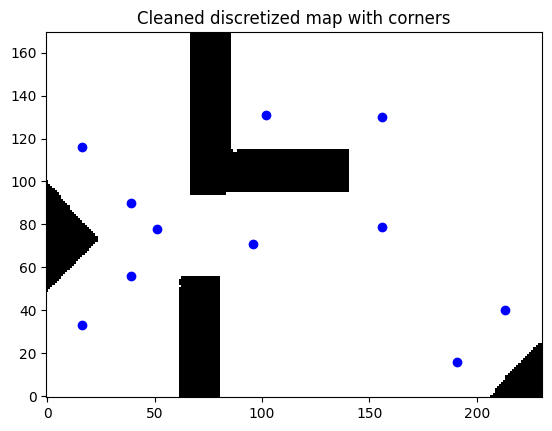

In [6]:
discretized_corners = gn.discretized_corners[::-1, ::-1]

plot_map(expanded_map, waypoints=discretized_corners, title="Expanded map with corners")
plot_map(cleaned_discretized_map, waypoints=discretized_corners, title="Cleaned discretized map with corners")

On the end of initialization, we build a graph from detected corners as the roadmap for the robot. To do that, for each point we find all reachable points (which means that thymio with its size can go by a straight line there) and add an edge between them.

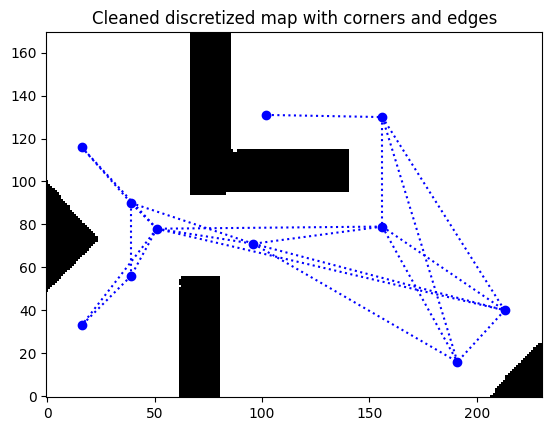

In [7]:
edges = gn.graph.get_edges()[:,:,::-1]

plot_map(cleaned_discretized_map, waypoints=discretized_corners, edges=edges, title="Cleaned discretized map with corners and edges")

To find the better road to each room, the `get_path()` function calculates the shortest path between two points using Dijkstra's algorithm and backtracking. It first maps the start and end points to the discretized grid using `discretize_point()` and adds them as temporary nodes to the graph. It also checks if the points are not in obstacles. The algorithm iteratively calculates distances between nodes and traces back through predecessors to reconstruct the optimal path. After all, it returns the path as a list of points and removes the temporary nodes from the graph making it useful for the next path planning.

Path found in 0.00834202766418457 seconds


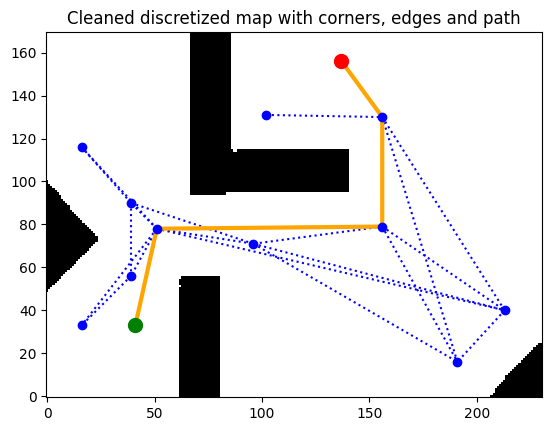

In [16]:
import numpy as np

thymio_position_in_pixel = np.array([250, 200]) # (x, y)
target_position_in_pixel = np.array([map_info.original_map.shape[0] - 200, map_info.original_map.shape[1] - 450]) # (x, y)

discretized_thymio_position = thymio_position_in_pixel // DESCRITIZE_SCALE
discretized_target_position = target_position_in_pixel // DESCRITIZE_SCALE

path = gn.get_path(thymio_position_in_pixel, target_position_in_pixel)
discretized_path = path // DESCRITIZE_SCALE

plot_map(
    cleaned_discretized_map, 
    waypoints=discretized_corners,
    robot_pos=discretized_thymio_position[::-1],
    target_pos=discretized_target_position[::-1],
    edges=edges, 
    path=discretized_path, 
    title="Cleaned discretized map with corners, edges and path"
)

Also, to move easily with the path, we implemented function `update_target_index()` which checks if the robot is close enough to the target point and if so, updates the target point to the next one in the path. If the robot is close to the last point, the target point is set to the end point.

# Kalman filter

The implementation of the Kalman Filter (`modules.kalman_filter.KalmanFilter`) in our project provides a robust and efficient framework for estimating the robot's position $(x,y)$ and orientation $(\theta)$ within the 2D museum environment. By integrating noisy sensor measurements with wheel velocity commands, the filter enables precise localization and navigation, even in the presence of measurement errors and environmental uncertainties. We mainly referenced [wikipedia](https://en.wikipedia.org/wiki/Kalman_filter) for the implementation.

Through its three core steps : prediction, measurement and correction, the Kalman Filter dynamically balances the influence of the robot’s motion model and sensors data. The state prediction step uses motion dynamics to estimate the robot’s next position, while the covariance prediction accounts for uncertainty in motion. The measurement update step refines these estimates by comparing them with real or simulated sensor readings, adjusting predictions through the Kalman gain to achieve a more accurate state.

The use of ArUco markers as external references strengthens the system's accuracy when available, while fallback mechanisms handle scenarios with limited external measurements when we hide the camera. The filter ensures the robot remains aware of its position and orientation, even in cases of incomplete or noisy data or suppression of his cameras. 

The key steps involve the prediction and correction phases, described below :

---

## Prediction

### State prediction equations

$$
\hat{x}_{k|k-1} = F_k  \cdot \hat{x}_{k-1|k-1} + B_k  \cdot u_k
$$

- $\hat{x}_{k-1|k-1}$: The predited state vector $(y_{k-1}, x_{k-1}, \theta_{k-1})$ from the information from first $k-1$ steps.
- $\hat{x}_{k|k-1}$: The predited state vector $(y_k, x_k, \theta_k)$ with the information from first $k-1$ steps.
- $F_k$ : State transition matrix, modeling the robot’s motion.
- $B_k$ : Control input matrix, scaling the impact of wheel velocity commands.
- $u_k$ : Control input vector, containing the velocities of the left and right wheels.

In our project, the matrices are defined as follows:

$$
F_k = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}, \quad
B_k =
\begin{bmatrix}
0.5 \cdot \Delta t \cdot \sin(\theta_k) & 0.5 \cdot \Delta t \cdot \sin(\theta_k) \\
0.5 \cdot \Delta t \cdot \cos(\theta_k) & 0.5 \cdot \Delta t \cdot \cos(\theta_k) \\
\frac{\Delta t}{d_r} & -\frac{\Delta t}{d_r}
\end{bmatrix}
$$

Where:
- $\Delta t$ : Time step between measurements.
- $\theta_k$ : Current orientation of the robot.
- $d_r$ : Distance between the robot’s wheels.

Derivation of the control input matrix and the state transition matrix : 

$$
\begin{aligned}
x_{k}= x_{k-1}+\Delta x &= x_{k-1}+ v_x \cdot \Delta t = v \cdot \sin(\theta) \cdot \Delta t\\
y_{k}= y_{k-1}+\Delta y &= y_{k-1}+ v_y \cdot \Delta t = v \cdot \cos(\theta) \cdot \Delta t
\end{aligned}
$$

With the velocity of the robot expressed as:
$v = \frac{v_\text{left} + v_\text{right}}{2}$

And the orientation update:
$\theta_{k} = \theta_{k-1}+\Delta \theta = \theta_{k-1}+ \frac{d_\text{right} - d_\text{left}}{d_r}$  

Where:
- $d_\text{right}$ is the distance traveled by the right wheel : $v_\text{right} \cdot \Delta t$
- $d_\text{left}$ is the distance traveled by the left wheel : $v_\text{left} \cdot \Delta t$
- $d_r$ is the distance between the two wheels.

So we have that : $\theta_{k} = \theta_{k-1} + \frac{v_\text{right} \cdot \Delta t - v_\text{left} \cdot \Delta t}{d_r} = \theta_{k} + \frac{v_\text{right} - v_\text{left}}{d_r} \cdot \Delta t$

Using the above mentioned formula we can know how to deduce the $(F_k)$ and $(B_k)$ matrices. 

---

### Covariance prediction equations

$$
P_{k|k-1} = F_k \cdot P_{k-1|k-1} \cdot F_k^\top + Q_k
$$

- $P_{k-1|k-1}$ : Predicted error covariance matrix at time $k-1$, from the information of first $k-1$ timesteps.
- $P_{k|k-1}$ : Predicted error covariance matrix at time $k$, from the information of first $k-1$ timesteps.
- $P_{k-1}$ : Covariance matrix from the previous time step.
- $Q_k$ : Process noise covariance matrix, modeling uncertainty in the robot's motion.

The matrix $Q_k$ is initially formed by combining the dynamic variances $\text{Var}(\Delta x)$, $\text{Var}(\Delta y)$, $\text{Var}(\Delta \theta)$ and the constant errors $\sigma_x$, $\sigma_y$, $\sigma_\theta$, giving us :

$$
Q_k =
\begin{bmatrix}
\text{Var}(\Delta x) & \text{Cov}(\Delta x, \Delta y) & \text{Cov}(\Delta x, \Delta \theta) \\
\text{Cov}(\Delta x, \Delta y) & \text{Var}(\Delta y) &  \text{Cov}(\Delta y, \Delta \theta) \\
 \text{Cov}(\Delta x, \Delta \theta) &  \text{Cov}(\Delta y, \Delta \theta) & \text{Var}(\Delta \theta)
\end{bmatrix}+ 
\begin{bmatrix}
\sigma_x^2 & 0 & 0 \\
0 & \sigma_y^2 & 0 \\
0 & 0 & \sigma_\theta^2
\end{bmatrix}
$$

We use the assumption: **the covariance matrix of $\Delta x$, $\Delta y$ and $\Delta \theta$ are only due to the uncertainty in the robot's velocity v, which is modeled as Gaussian noise with variance $\sigma_v=\sigma_{v,rel}v+\sigma_{v,abs}$**. Here $\sigma_{v,rel}$ and $\sigma_{v,abs}$ are the relative and absolute error of velocity measurement respectively. We then derive $\Delta x$, $\Delta y$ and $\Delta \theta$ as follows:

$$
\begin{aligned}
\Delta x &= \Delta t\sin(\theta)\frac{\Delta v_\text{left} + \Delta v_\text{right}}{2}\\
\Delta y &= \Delta t\cos(\theta)\frac{\Delta v_\text{left} + \Delta v_\text{right}}{2}\\
\Delta \theta &= \Delta t\frac{\Delta v_\text{left} - \Delta v_\text{right}}{d_r}
\end{aligned}
$$

Here we define $\sigma_v=\sigma_{v,rel}v+\sigma_{v,abs}$ From the above we can calculate the covariance terms:

$$
\begin{aligned}
\text{Var}(x)&=\mathbb{E}\left[(\Delta x-\overline{\Delta x})(\Delta x-\overline{\Delta x})\right]\\
&=\mathbb{E}\left[\Delta x\Delta x\right]\\
&=\mathbb{E}\left[\sin(\theta)^2\left(\frac{\Delta v_\text{left}^2 + \Delta v_\text{right}^2 + 2\Delta v_\text{left}\Delta v_\text{right}}{4}\right)\right]\\
&=\Delta t^2\sin(\theta)^2\left(\frac{\sigma_{v_{left}}^2 + \sigma_{v_{right}}^2}{4}\right)\\
\text{Var}(\theta)&=\mathbb{E}\left[\left(\Delta\theta-\overline{\Delta\theta}\right)^2\right]\\
&=\mathbb{E}\left[\left(\frac{\Delta v_\text{left} - \Delta v_\text{right}}{d_r}\right)^2\right]\\
&=\mathbb{E}\left[\frac{\Delta v_\text{left}^2 - \Delta v_\text{right}^2}{d_r^2}\right]\\
&=\Delta t^2\frac{1}{d_r^2}\left(\sigma_{v_{left}}^2 + \sigma_{v_{right}}^2\right)\\
\text{Cov}(x,y)&=\mathbb{E}\left[(\Delta x-\overline{\Delta x})(\Delta y-\overline{\Delta y})\right]\\
&=\mathbb{E}\left[\Delta x\Delta y\right]\\
&=\mathbb{E}\left[\sin(\theta)\frac{\Delta v_\text{left} + \Delta v_\text{right}}{2}\cos(\theta)\frac{\Delta v_\text{left} + \Delta v_\text{right}}{2}\right]\\
&=\mathbb{E}\left[\sin(\theta)\cos(\theta)\left(\frac{\Delta v_\text{left}^2 + \Delta v_\text{right}^2}{4}+\frac{\Delta v_\text{left}\Delta v_\text{right}}{2}\right)\right]\\
&=\mathbb{E}\left[\sin(\theta)\cos(\theta)\left(\frac{\Delta v_\text{left}^2 + \Delta v_\text{right}^2}{4}\right)\right]\\
&=\Delta t^2\sin(\theta)\cos(\theta)\frac{\sigma_{v_{left}}^2 + \sigma_{v_{right}}^2}{4}\\
\text{Cov}(x,\theta)&=\mathbb{E}\left[(\Delta x-\overline{\Delta x})(\Delta \theta-\overline{\Delta \theta})\right]\\
&=\mathbb{E}\left[\Delta x\Delta \theta\right]\\
&=\mathbb{E}\left[\Delta t^2\sin(\theta)\frac{\Delta v_\text{left} + \Delta v_\text{right}}{2}\frac{\Delta v_\text{left} - \Delta v_\text{right}}{d_r} \right]\\
&=\Delta t^2\sin\theta \frac{\sigma_{v_{left}}^2 - \sigma_{v_{right}}^2}{2d_r}\\
\text{Cov}(y,\theta)&=\mathbb{E}\left[(\Delta y-\overline{\Delta y})(\Delta \theta-\overline{\Delta \theta})\right]\\
&=\mathbb{E}\left[\Delta y\Delta \theta\right]\\
&=\mathbb{E}\left[\Delta t^2\cos(\theta)\frac{\Delta v_\text{left} + \Delta v_\text{right}}{2}\frac{\Delta v_\text{left} - \Delta v_\text{right}}{d_r} \right]\\
&=\Delta t^2\cos\theta \frac{\sigma_{v_{left}}^2 - \sigma_{v_{right}}^2}{2d_r}\\
\end{aligned}
$$

The actual $Q$ matrix can be constructed using the above derived formula for the covariance and variance terms.

<!-- Using error propagation, we have that :

$\text{Var}(\Delta x) = \left( \frac{\partial \Delta x}{\partial v_\text{right}} \right)^2 \cdot \sigma_{v_\text{right}}^2 + \left( \frac{\partial \Delta x}{\partial v_\text{left}} \right)^2 \cdot \sigma_{v_\text{left}}^2 = 2 \cdot \left( \Delta t \cdot \cos(\theta_k) \right)^2 \cdot \sigma_v^2$,   assuming $(\sigma_{v_\text{right}}^2 = \sigma_{v_\text{left}}^2 = \sigma_v^2)$

$\text{Var}(\Delta y) = \left( \frac{\partial \Delta y}{\partial v_\text{right}} \right)^2 \cdot \sigma_{v_\text{right}}^2 + \left( \frac{\partial \Delta y}{\partial v_\text{left}} \right)^2 \cdot \sigma_{v_\text{left}}^2 = 2 \cdot \left( \Delta t \cdot \sin(\theta_k) \right)^2 \cdot \sigma_v^2$,   assuming $(\sigma_{v_\text{right}}^2 = \sigma_{v_\text{left}}^2 = \sigma_v^2)$

$\text{Var}(\Delta \theta) = \left( \frac{\partial \Delta \theta}{\partial v_\text{right}} \right)^2 \cdot \sigma_{v_\text{right}}^2 + \left( \frac{\partial \Delta \theta}{\partial v_\text{left}} \right)^2 \cdot \sigma_{v_\text{left}}^2 = 2 \cdot \left( \frac{\Delta t}{d_r} \right)^2 \cdot \sigma_v^2$,   assuming $(\sigma_{v_\text{right}}^2 = \sigma_{v_\text{left}}^2 = \sigma_v^2)$ -->

---
## Measurement prediction

### Measurement prediction equations

$$
\tilde{y}_k = z_k - H_k \cdot \hat{x}_{k|k-1}
$$

- $\tilde{y}_k$ : Measurement difference vector at time $k$, includes $(y_k, x_k, \theta_k)$.
- $H_k$ : Observation matrix, relates the predicted state to the actual measurement.
- $z_k$ : Real measurement.

In our project, the observation matrix and measurement is defined as :

$$
\begin{aligned}
H_k &= 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}\\
z_k &= 
\begin{bmatrix}
x_{\text{measure}} \\
y_{\text{measure}} \\
\theta_{\text{measure}}
\end{bmatrix}
\end{aligned}
$$

We also define the measurement uncertainty matrix for the next step (correction). Our definition is based on a simple camera model: assume the camera has a shutter speed of $t_s$ second, each pixel corresponds to $l_p$ centimeters on the map, the speed of the robot is $v$, the width of the aruco marker we used is $d_a$ centimeters. Then we can know :

$$
\begin{aligned}
\sigma_x^2&=\Theta(v_x^2t_s^2)+\Theta(l_p^2) \leq \Theta(v^2t_s^2)+\Theta(l_p^2)\\
\sigma_y^2&=\Theta(v_y^2t_s^2)+\Theta(l_p^2) \leq \Theta(v^2t_s^2)+\Theta(l_p^2)\\
\sigma_\theta^2&=\Theta\left(\frac{(v_\text{right}-v_\text{left})^2t_s^2}{d_a^2}\right)+\Theta\left(\frac{l_p^2}{d_a^2}\right)
\end{aligned}
$$

Since the measurement of camera is already very accurate, we did some relaxations to obtain the upperbound of the variances. For simplicity, we assume the constants related to the $\Theta$ symbols are all $1$. Thus the measurement uncertainty matrix is:

$$
R_k=\begin{bmatrix}
v^2t_s^2+l_p^2 & 0 & 0\\
0 & v^2t_s^2+l_p^2 & 0\\
0 & 0 & \frac{(v_\text{right}-v_\text{left})^2t_s^2+l_p^2}{d_a^2}
\end{bmatrix}
$$

Sometimes we cannot detect the aruco for the robot, we then replace the uncertainty matrix with:

$$
  R_k = 
  \begin{bmatrix}
  +\infty & 0 & 0 \\
  0 & +\infty & 0 \\
  0 & 0 & +\infty
  \end{bmatrix}
  $$

---

## Update with correction

### Kalman gain equation

#### 1. Innovation covariance
$$
S_k = H_k P_{k|k-1} H_k^\top + R_k
$$

- $S_k$ : Covariance of the residual.
- $P_{k|k-1}$ : Predicted covariance matrix before the update.
- $H_k$ : Observation matrix.
- $R_k$ : Measurement noise covariance matrix.

#### 2. Kalman gain

$$
K_k = P_{k|k-1} H_k^\top S_k^{-1}
$$

- $K_k$: Kalman gain matrix, determining how much to adjust the prediction based on the measurement.

### State a posteriori equation

$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k \tilde{y}_k
$$

- $\hat{x}_{k|k}$: Updated state estimate after incorporating the measurement of timestep $k$.
- $\hat{x}_{k|k-1}$: Predicted state vector before the update.
- $K_k$: Kalman gain.
- $\tilde{y}_k$: Measurement residual.

---

### Covariance a posteriori equation
$$
P_{k|k} = (I - K_k H_k) P_{k|k-1}
$$

- $P_{k|k}$: Updated covariance matrix after incorporating the measurement.
- $I$: Identity matrix.
- $K_k$: Kalman gain.
- $H_k$: Observation matrix.
- $P_{k|k-1}$: Predicted covariance matrix before the update.

## Kidnapping Detection

The Kalman Filter also does the job to detect possible kidnappings and reset the robot state when kidnappings happens.

The logic for detecting Kidnapping is really simple, but effective:

```python
maybe_hijack = False
if aruco_available and (np.abs(measure_x-last_x) > 10 or np.abs(measure_y-last_y) > 10) :
    self.last_P = self.init_P   # init_P is a diagonal matrix of infinity
    maybe_hijack = True
```

The state resetting is implemented with setting the estimation covariance matrix to a diagonal matrix of infinity. This allows the kalman Filter to automatically reset the state at the next timestep.

## Example

We have plotted the covariance of $x$ and $y$, and the variance of $\theta$ in real time. We used and ellipse to indicate the distribution of $(x,y)$ within $1\sigma, 2\sigma, 3\sigma$. We also used three sectors to indicate the variance of $\theta$ . The visualization looks like the plot below.

![](resources/figures/Kalman.png)

We can generate a simple test case to test the kalman filter:

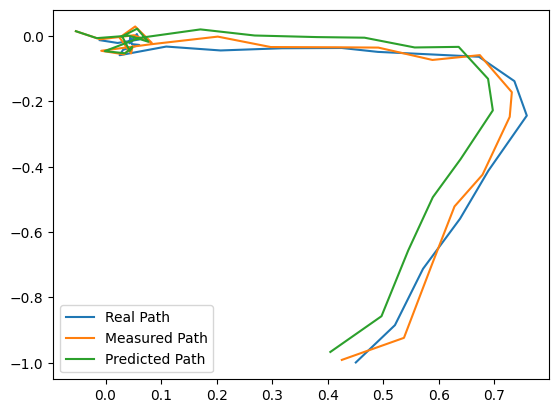

In [9]:
from modules.kalman_filter import KalmanFilter, generate_testcase
from matplotlib import pyplot as plt

# Generate a testcase
d_robot = 0.1
dt = 0.1

(
    x_real_list,
    y_real_list,
    theta_real_list,
    x_measure_list,
    y_measure_list,
    theta_measure_list,
    vl_list,
    vr_list,
) = generate_testcase(d_robot, dt)

# Instantiate the Kalman Filter
kf = KalmanFilter(
    t_frame=0.01,
    d_pixel=0.01,
    d_robot=d_robot,
    d_aruco=0.05,
    v_error=0.05
)
x_pred = -1
y_pred = -1
x_pred_list = []
y_pred_list = []
theta_pred_list = []

for x_measure, y_measure, theta_measure, vl, vr in zip(
    x_measure_list,
    y_measure_list,
    theta_measure_list,
    vl_list,
    vr_list
) :
    x_pred, y_pred, theta_pred, hijack = kf.get_prediction(
        x_pred,
        y_pred,
        theta_measure,
        x_measure,
        y_measure,
        theta_measure,
        vl,
        vr,
        dt,
        True
    )
    x_pred_list.append(x_pred)
    y_pred_list.append(y_pred)
    theta_pred_list.append(theta_pred)
    # print(f"x_pred: {x_pred}, y_pred: {y_pred}, theta_pred: {theta_pred}")

plt.plot(x_real_list, y_real_list, label="Real Path")
plt.plot(x_measure_list, y_measure_list, label="Measured Path")
plt.plot(x_pred_list, y_pred_list, label="Predicted Path")
plt.legend()
plt.show()

# PID controller

The PID Controller (`modules.motor.PIDController`) is a key component in ensuring the Thymio follows its path accurately, whether navigating toward a target point. Our controller combines proportional, integral, and derivative (PID) control to compute the wheel speeds needed to adjust the direction of the robot by using both linear and angular corrections. The linear error is the straight-line distance between the robot's current position and the target and the angular error is  the angle between the robot's current heading and the direction to the target, normalized to stay within $[−π,π]$ and clipped between $[-1, 1]$ radians to keep the angular speed within a practical range and ensuring the angular correction remains smooth and gradual. 

The left speed and right speed of the wheels are obtained by manipulating the linear and angular speed founds from linear and angular errors. 


The PID controller adjusts the linear and angular speeds by combining three components : a proportional term reflecting directly the current linear or angular error to do immediate corrections, an integral term that accumulates past errors to compensate for incorrect deviations over time, and a derivative term that predicts future error changes, smoothing the overall response. These components are weighted by `kp`, `ki` and `kd` coefficients to fixe both linear and angular speeds, and are tuned through iterative testing to optimize the robot’s performance and initialized in the PID class : 

```python
linear_speed = (self.kp_linear * distance_to_target +
                self.ki_linear * self.integral_linear +
                self.kd_linear * derivative_linear
               )

angular_speed = (self.kp_angular * alpha_error +
                 self.ki_angular * self.integral_angular +
                 self.kd_angular * derivative_angular
                )
```

To determine the wheel speeds, when the angular error is significant $(∣\alpha_{error}∣>0.4)$, the robot prioritizes correcting its direction by focusing entirely on angular motion, and in the contrary case, it focalises more on linear motion. 

For blending linear and angular speeds contributions, we used a ration that by balancing the `linear_speed` and `angular_speed` variables, allows the robot to move forward while making necessary adjustments to its heading : 

```python
if np.abs(alpha_error) > 0.4:
    ratio = 1
else:
    ratio = 0.2 + 0.8 * np.abs(alpha_error) / 0.4

left_speed = (1-ratio) * linear_speed + ratio * angular_speed
right_speed = (1-ratio) * linear_speed - ratio * angular_speed

# Limiting speeds
clipping_ratio = max(max(abs(left_speed), abs(right_speed) + 1) / self.max_speed, 1)
left_speed = left_speed / clipping_ratio
right_speed = right_speed / clipping_ratio
```

# Local Navigation 

The Local Navigation controller (`modules.local_navigation.LocalNavigation`) controls the robot's movement by adjusting its wheel speeds based on readings from the five front proximity sensors to avoid obstacles. When there are no obstacles on the path, the robot remains in the "running" state, moving forward with motions calculated by the PID controller to follow the global path. 

As the robot approaches an obstacle, the proximity sensor values increase. However, to enable intuitive reasoning by thinking in terms of distance to the obstacle, we invert the sensor readings using the following formula : 

```python
prox = detection_distance - prox_horizontal[:5]
```

So that the prox array values become proportional to the distance from the obstacle (`detection_distance` : the max value that can be readed by the sensors, so that the prox values can only vary between 5000(very far obstacle), to a positive value near to 0 (very close to the obstacle)). 

Since we need to avoid large obstacles robustly without hitting them, the robot should keep moving sideways from the obstacle for some period of time. We used a Finite State Machine (FSM) to meet this requirement. There are 3 states in the FSM:

- Running: keep using signals from global navigation and pid. If an obstacle is detected in this case, but it is not close to the robot, then change the moving direction of robot by an angle inversely proportional to the distance.
- Avoiding: a near obstacle is detected, robot turning in place. The turning direction is determined by which sensor detected the obstacle.
- Backup: after avoiding state, the robot keeps running a period of time (determined by parameter `avoiding_period`) sideways from the obstacle.

Thanks to the `get_obstacle_status()` function which returns how far the obstacle is (near obstacle, far obstacle, no obstacle), the state transitions are implemented like following :

- Running => Running : No near obstacle detected.
- Running => Avoiding : Near obstacle detected.
- Avoiding => Backup: No obstacle detected.
- Avoiding => Avoiding : Obstacle detected.
- Backup => Avoiding : Near obstacle detected.
- Backup => Running : No near obstacle detected, and Backup has been executed for over `avoiding_period`.
- Backup => Backup : Otherwise.

The criteria for determine far and near obstcale are :

- Far obstacle : If any prox value is between 2000 and 4000 units, the presence of nearby obstacles is detected, and first avoidance actions are taken.
- Near obstacle : If one of the prox values <= 2000 units, the obstacle becomes very close, and the robot enters the "avoiding" state.

For different states, we implemented different policy to control the robot:

- Running : This state means the robot is running freely, or has detected far objects. In this case, we rotate the speed vector provided by PID control by an angle determined by `bias` radians. The bias is calculated to steer the robot away from the obstacle, allowing us to treat it as an angle that we apply in a rotation matrix, because it represents a directional adjustment in the robot's movement. This rotation matrix adjusts the motor speeds calculated by the PID controller, enabling the robot to turn smoothly and do small controlled maneuvering around the obstacles.
- ```python
  bias = 0

  sensor_influence = {
      0: -2.0,
      1: 0.0,
      2: 0.0,
      3: 0.0,
      4: 2.0
  }

  bias += magnitude / self.detection_distance * sensor_influence[i]
  motor_speeds = [np.cos(bias) * motor_speeds[0] - np.sin(bias) * motor_speeds[1], 
                  np.sin(bias) * motor_speeds[0] + np.cos(bias) * motor_speeds[1]]
  ```
- Avoiding : This state means the robot has detected a near obstacle. It will turn away from the obstacle:
- ```python
  obstacle_pos = np.argmin(np.where(prox_horizontal[:5]<=0, np.inf, self.detection_distance-prox_horizontal[:5]))

  if obstacle_pos <= 2:
      motor_speeds[0] = self.max_speed
      motor_speeds[1] = -self.max_speed
  else :
      motor_speeds[0] = -self.max_speed
      motor_speeds[1] = self.max_speed
  ```
- Backup : This state means the robot is going sideways from the obstacle:
- ```python
  back_up_weight = 1 - (time.time() - self.current_state_time) / self.avoiding_period
  if back_up_weight > 0.5 :
      back_up_weight = 1
  else :
      back_up_weight = 0.75   # for smooth transition from back up to normal state

  motor_speeds[0] = self.max_speed * back_up_weight + motor_speeds[0] * (1 - back_up_weight)
  motor_speeds[1] = self.max_speed * back_up_weight + motor_speeds[1] * (1 - back_up_weight)
  ```

As the back-up period progresses, the `back_up_weight` decreases, reducing the influence of the corrective term. This reduction allows the robot to transition smoothly back to the PID-calculated speeds, resuming its normal navigation toward the global path.

# Path Controller

Path controller (`modules.controller.Controller`) provides the Thymio the ability to go from A to B.

The controller has only one function `Controller.run(path)` . Upon calling, the controller will repeat the following steps until reached the final waypoint on the path:

- Get current camera frame.
- Update robot pose based on the frame.
- Choose the next waypoint on the path based on the updated robot pose.
- Calculate wheel speed by PID controller to move to next waypoint.
- Update or override wheel speed by Local Navigation.
- Send motor speed command to Thymio.

# Mission Planner

The mission planner `MainLogic` will control the robot's highest-level behavior: patrolling or chasing the intruder.

During routine patrols, whenever Thymio reaches a designated room, that location becomes the new starting point, and the next room on its patrol mission becomes the new goal.

As Thymio carries out its patrol, the system dynamically adapts to unexpected events. When an intruder is detected, the intruder becomes the new target. This target is immediately added to the map as a new point of interest, triggering the calculation of a new global path to intercept the intruder while avoiding obstacles. If the intruder tries to confuse Thymio by momentarily disappearing from view, the robot remains vigilant. The moment the intruder’s ArUco marker reappears, Thymio detects it instantly, recalculating its path to adapt to the intruder's new position. This real-time adaptability ensures that Thymio stays on track, seamlessly transitioning between routine surveillance and reactive pursuit, no matter how unpredictable the intruder's movements.

The abstracted behavior is as follows:

- By default, the robot should go patrolling. Patrolling is a infinite loop of several waypoints.
- If intruder is detected at a new position, stop current routine and move to the new position.
- If reached the intruder position, back to previous patrolling routine.

The behavior requires us to use a mechanism that can **stop** running behavior and switch to another. We choose multithreading to make it work. In the `MainLogic.run()` function, the main thread will first launch a listener thread `listener_thread = Thread(target=self.listen_for_target)`, which is running in the background to analyze camera frame once every second.

The `listen_for_target()` function in the `listener_thread` will set `next_target` to `True` once a new target appears, and send cancellation signal to the main thread to terminate current path with a `CancellationToken()` class. When the Path Controller in the main thread received the cancellation signal, it will stop the current path and get the new path target.

In the main thread, we used an iterator to get new path targets.

```python
def get_next_waypoint(self):  # The waypoint itetrator
    while True:
        if self.next_target is not None:
            target = self.next_target
            self.next_target = None
            yield target
        else:
            next_checkpoint = self.checkpoints[self.next_checkpoint_index]
            self.next_checkpoint_index = (self.next_checkpoint_index + 1) % len(self.checkpoints)
            yield next_checkpoint
  
for next_target in self.get_next_waypoint():  # Iterate through new targets
    print("Current position", self.controller.current_position)
    print("Going to", next_target)

    self.cancel_token = CancellationToken()
    self.controller.run(next_target, self.cancel_token)
```

This function will return the intruder location if the intruder is present. Otherwise returns the next checkpoint of patrol
. For each iteration, we run the Path Controller to move the robot to the target point. When interruptions happen (a new intruder was found), the `cancel_token` will be set to `True` so the controller will terminate and return, then the iteration will continue.

This iteration provides our Thymio the ability to be interruped with emergency and return to normal patrolling routine when emergency resolved.

# Conclusion 

Through this project, we successfully developed an autonomous system capable of addressing the challenges of surveillance and intruder pursuit within a museum environment.

The vision system was a cornerstone of the project, accurately identifying the Thymio's location and pinpointing the intruder's position. Its precision and reliability ensured that the robot consistently maintained awareness of its surroundings.

The navigation strategy demonstrated good results. The global planner provided optimal routes through the museum layout, while the local navigation module allowed the robot to dynamically avoid unexpected obstacles thrown by the intruder in a pretty good way.

One of the standout achievements was the ability of the system to handle extreme scenarios, such as the robot being displaced or "kidnapped" to another part of the museum. The Kalman filter proved invaluable in these instances, recalculating Thymio's position with accuracy and enabling it to resume its mission without interruption.

The pursuit mechanism showcased Thymio’s capacity to follow the intruder effectively, recalibrating its global path as the scenario evolved. This, combined with precise motion control through a PID controller, ensured smooth and accurate movement.

Ultimately, the system succeeded in its mission: Thymio was able to monitor the museum, adapt to unpredictable challenges, and track down the intruder.  
On a personal level, this project provided us the opportunity to gain hands on experience in building complex, real world systems. Additionally, collaborating with individuals we hadn’t worked with before challenged us to adapt, communicate effectively, and integrate diverse perspectives, which enriched the overall experience and prepared us for future multidisciplinary endeavors.

# References

- Moodle of the course: https://moodle.epfl.ch/course/view.php?id=15293#section-0
- OpenCV-Python: https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html
- Numpy Documentation: https://numpy.org/doc/stable/
- Thymio Control: https://github.com/epfl-mobots/tdm-python/blob/main/doc/notebooks.md
- Kalman filter: https://en.wikipedia.org/wiki/Kalman_filter
- Shi tomasi algorithm: https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html
- Dijkstra algorithm: https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm
- Breadth first search: https://en.wikipedia.org/wiki/Breadth-first_search
- Chat GPT: https://chatgpt.com


# Example Video

<video controls>
  <source src="video/T23_bomr_example.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>